In [1]:
import pandas as pd

# adjust the path if you’re running locally;
# on Kaggle these files live under /kaggle/input/twitter/
train_df = pd.read_csv('/kaggle/input/twitter/train_kaggle.csv')
test_df  = pd.read_csv('/kaggle/input/twitter/test_kaggle.csv')

# print the first five rows of each
print("─── TRAIN ───")
print(train_df.head(), "\n")

print("─── TEST ───")
print(test_df.head())

─── TRAIN ───
   ID                                               text  label
0   0          i feel intelligent and insightful as well      1
1   1  i like tea a lot but i think that most of the ...      1
2   2  i feel that poe through his own tortured exist...      3
3   3  i feel is intelligent i d really prefer a clea...      1
4   4  i remember as a small child feeling frightened...      4 

─── TEST ───
   ID                                               text
0   0  i feel blessed to have been able to spend one ...
1   1  i really hope im in good condition to make thi...
2   2  i bet you have a really good reason but if you...
3   3  im not sure if this is normal for pageant girl...
4   4  i find out stuff all the more i feel doubtful ...


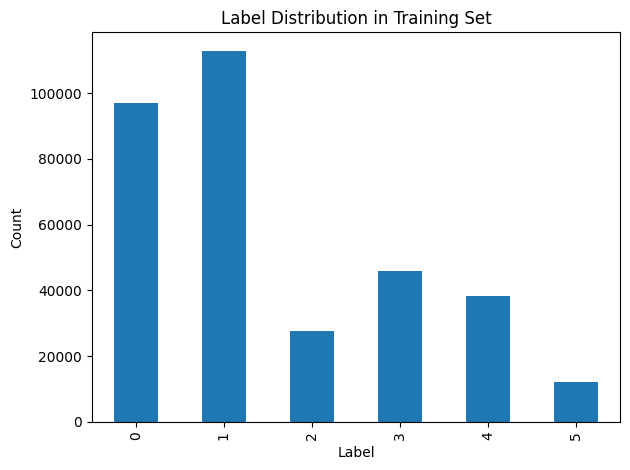

In [2]:
import matplotlib.pyplot as plt
# -------------------------
# Visualization: Label Distribution
# -------------------------
label_counts = train_df['label'].value_counts().sort_index()
plt.figure()
label_counts.plot(kind='bar')
plt.title('Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import re
import unicodedata
from sklearn.preprocessing    import LabelEncoder
from sklearn.model_selection  import train_test_split
from torch.utils.data         import Dataset, DataLoader, WeightedRandomSampler
from transformers             import (
    AutoTokenizer,
    DataCollatorWithPadding,
)

###############################
# 1) Cleaning & Filtering
###############################

def clean_data(df, text_col="text"):
    # unicode normalize
    df[text_col] = df[text_col].apply(lambda t: unicodedata.normalize("NFC", t))
    # lowercase (Roberta tokenizer lowercases by default, but no harm)
    df[text_col] = df[text_col].str.lower()
    # remove URLs
    df[text_col] = df[text_col].str.replace(r"http\S+", "", regex=True)
    # remove mentions
    df[text_col] = df[text_col].str.replace(r"@\w+", "", regex=True)
    # strip hashtags (keep the tag text)
    df[text_col] = df[text_col].str.replace(r"#(\w+)", r"\1", regex=True)
    # remove stray punctuation (optional)
    df[text_col] = df[text_col].str.replace(r"[^a-z0-9\s\!\?]", "", regex=True)
    # collapse multiple spaces
    df[text_col] = df[text_col].str.replace(r"\s+", " ", regex=True).str.strip()
    return df

def remove_outliers(df, text_col="text", min_len=3, max_len=128):
    # drop too-short or too-long tweets
    lengths = df[text_col].str.split().str.len()
    return df[(lengths >= min_len) & (lengths <= max_len)]

###############################
# 2) Prepare splits
###############################

# assume `train_df` & `test_df` are your raw pandas DataFrames
train_df = clean_data(train_df)
train_df = remove_outliers(train_df)

test_df  = clean_data(test_df)

# stratified split
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df.label
)

###############################
# 3) Tokenizer & Dataset
###############################

MODEL_NAME = "distilroberta-base"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)

class EmotionDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128):
        self.texts      = texts
        self.labels     = labels
        self.tokenizer  = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {
            "input_ids":      enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
        }
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# label encoding
le = LabelEncoder()
train_labels = le.fit_transform(train_df.label)
val_labels   = le.transform(val_df.label)

train_ds = EmotionDataset(train_df.text.tolist(), train_labels, tokenizer)
val_ds   = EmotionDataset(val_df.text.tolist(),   val_labels,   tokenizer)
test_ds  = EmotionDataset(test_df.text.tolist(),  labels=None,  tokenizer=tokenizer)

###############################
# 4) Weighted Sampler
###############################

# compute class weights
class_sample_count = np.bincount(train_labels)
class_weights      = 1. / class_sample_count
sample_weights     = class_weights[train_labels]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

###############################
# 5) DataLoaders w/ Collator
###############################

collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    sampler=sampler,       # or shuffle=True if you skip weighting
    collate_fn=collator
)
val_loader = DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False,
    collate_fn=collator
)
test_loader = DataLoader(
    test_ds,
    batch_size=64,
    shuffle=False,
    collate_fn=collator
)



2025-05-23 09:17:10.058081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747991830.260386      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747991830.318935      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm

# 1) Setup
MODEL_NAME   = "distilroberta-base"
NUM_LABELS   = 6
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS       = 10
LEARNING_RATE= 2e-5
BATCH_SIZE   = 32   # your train_loader already uses this
ACCUM_STEPS  = 1    # increase if you need gradient accumulation

# 2) Model, optimizer, scheduler, scaler
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS
).to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

total_steps = len(train_loader) // ACCUM_STEPS * EPOCHS
scheduler   = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=total_steps // 10,  # 10% warmup
    num_training_steps=total_steps
)

# for mixed-precision
scaler = torch.cuda.amp.GradScaler()

# 3) Training & evaluation functions
def train_epoch(loader):
    model.train()
    losses = []
    for batch in tqdm(loader, desc="Train"):
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["labels"].to(DEVICE)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss / ACCUM_STEPS

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        losses.append(loss.item() * ACCUM_STEPS)

    return sum(losses) / len(losses)


def eval_model(loader):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval"):
            input_ids      = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels         = batch["labels"].to(DEVICE)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=-1).cpu().numpy()
            preds.extend(batch_preds)
            true.extend(labels.cpu().numpy())

    acc = accuracy_score(true, preds)
    f1  = f1_score(true, preds, average="macro")
    return acc, f1



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/2862092571.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [7]:
# 4) Main loop
best_f1 = 0.0
for epoch in range(1, EPOCHS + 1):
    print(f"\n=== Epoch {epoch}/{EPOCHS} ===")
    train_loss = train_epoch(train_loader)
    val_acc, val_f1 = eval_model(val_loader)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val   Acc:  {val_acc:.4f} | Val Macro-F1: {val_f1:.4f}")

    # save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pt")
        print("→ Saved new best model")



=== Epoch 1/10 ===


Train:   0%|          | 0/8334 [00:00<?, ?it/s]

/tmp/ipykernel_35/2862092571.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Eval:   0%|          | 0/1042 [00:00<?, ?it/s]

Train Loss: 0.3465
Val   Acc:  0.9387 | Val Macro-F1: 0.9132
→ Saved new best model

=== Epoch 2/10 ===


Train:   0%|          | 0/8334 [00:00<?, ?it/s]

/tmp/ipykernel_35/2862092571.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Eval:   0%|          | 0/1042 [00:00<?, ?it/s]

Train Loss: 0.1150
Val   Acc:  0.9426 | Val Macro-F1: 0.9176
→ Saved new best model

=== Epoch 3/10 ===


Train:   0%|          | 0/8334 [00:00<?, ?it/s]

/tmp/ipykernel_35/2862092571.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Eval:   0%|          | 0/1042 [00:00<?, ?it/s]

Train Loss: 0.1062
Val   Acc:  0.9427 | Val Macro-F1: 0.9177
→ Saved new best model

=== Epoch 4/10 ===


Train:   0%|          | 0/8334 [00:00<?, ?it/s]

/tmp/ipykernel_35/2862092571.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Eval:   0%|          | 0/1042 [00:00<?, ?it/s]

Train Loss: 0.1005
Val   Acc:  0.9430 | Val Macro-F1: 0.9176

=== Epoch 5/10 ===


Train:   0%|          | 0/8334 [00:00<?, ?it/s]

/tmp/ipykernel_35/2862092571.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


KeyboardInterrupt: 

In [8]:
# --- 7) Load & Test (unchanged) ---
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
all_test_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        logits = model(
            batch["input_ids"].to(DEVICE),
            attention_mask=batch["attention_mask"].to(DEVICE)
        ).logits
        all_test_preds.extend(logits.argmax(dim=-1).cpu().numpy())

final_labels = le.inverse_transform(all_test_preds)

Test:   0%|          | 0/1303 [00:00<?, ?it/s]

In [9]:
# 1) Gather IDs in the same order as your predictions
test_ids = test_df["ID"].tolist()

# 2) Build the submission DataFrame
submission = pd.DataFrame({
    "ID":    test_ids,
    "label": final_labels
})

# 3) Save to CSV (no index)
submission.to_csv("submission.csv", index=False)

print("Wrote submission.csv with", len(submission), "rows.")

Wrote submission.csv with 83362 rows.


In [10]:
submission.head(9)

,ID,label
0,0,2
1,1,2
2,2,4
3,3,2
4,4,4
5,5,3
6,6,4
7,7,0
8,8,0


In [11]:
from IPython.display import FileLink

# If you saved it as /kaggle/working/best_model.pt, just:
FileLink("best_model.pt")


/kaggle/working/best_model.pt